In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
import psutil
from torch.optim import lr_scheduler

In [3]:
time = np.arange(0,1002,0.1)
#sin  = np.sin(time)*0.6
#sin  = (np.sin(time) + np.sin(2*time))*0.6/2
#sin  = (np.sin(time) + np.sin(2*time))*0.6/2 + np.random.rand(len(time))*0.2
sin  = (np.sin(time) - np.sin(2*time) + np.sin(3*time))*0.6/3 + np.random.rand(len(time))*0.2
fut_5  = sin[5:]
fut_10 = sin[10:]
fut_15 = sin[15:]
fut_20 = sin[20:]

In [4]:
df = pd.DataFrame(
    data = sin[:10000],
    index= time[:10000],
    columns = ["data"]
)
df["Future_5"]  = fut_5[:10000]
df["Future_10"] = fut_10[:10000]
df["Future_15"] = fut_15[:10000]
df["Future_20"] = fut_20[:10000]

df["history_5"] = pd.Series(df["data"].rolling(window=5)).values
df["history_10"] = pd.Series(df["data"].rolling(window=10)).values

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
        data_df
    ):
        self.list_IDs   = list_IDs
        self.cache      = {}
        self.data_df    = data_df
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torch.tensor(self.data_df.loc[ID]["history_10"].values, dtype=torch.float32)
            #X = torch.tensor(self.data_df.loc[ID]["history_10"].values, dtype=torch.float32)
            Y = torch.tensor(self.data_df.loc[ID]["Future_10"], dtype=torch.float32)
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X': X,
                    'Y': Y
                }
                self.cache[ID] = data
        return X,Y
data = df[10:]
ids = data.index.values
train_ids = ids[:8000]
test_ids  = ids[8000:]

params = {
    'batch_size' : 32,
    'shuffle'    : True,
    'num_workers': 2
}

In [6]:
training_set         = Dataset( train_ids, data )
training_generator   = torch.utils.data.DataLoader( training_set, **params, pin_memory=True ) 
validation_set       = Dataset( test_ids, data )
validation_generator = torch.utils.data.DataLoader( validation_set, **params, pin_memory=True )

In [7]:
real = np.zeros(len(train_ids))
j = 0
for i,batch in enumerate(training_generator):
    real[j:j+batch[0].shape[0]] = batch[1]
    j += batch[0].shape[0]

In [8]:
device = torch.device("cuda")

In [9]:
def train_one_epoch(model, loss_fn):
    model.train()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(1).to(device)
        Y = batch[1].unsqueeze(1).unsqueeze(1).to(device)
        optimizer.zero_grad()
        output,hn  = model(X)
        loss    = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        running_loss += loss
    return running_loss/(i+1)

def val_one_epoch(model, loss_fn):
    model.eval()
    running_loss = 0.
    for i,batch in enumerate(training_generator):
        X = batch[0].unsqueeze(1).to(device)
        Y = batch[1].unsqueeze(1).unsqueeze(1).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output,hn  = model(X)
        loss    = loss_fn(output, Y)
        running_loss += loss
    return running_loss/(i+1)

def train(model, epochs=10):
    loss_fn = torch.nn.L1Loss()
    train_loss = []
    val_loss   = []
    
    for epoch in range(epochs):
        model.train(True)
        print("EPOCHS: ", epoch + 1)
        loss = train_one_epoch(model, loss_fn=loss_fn)
        print("train loss: ",loss)
        train_loss.append(loss)
        model.train(False)
        loss = val_one_epoch(model, loss_fn=loss_fn)
        val_loss.append(loss)
        print("val loss: ",loss)
        scheduler.step()
    return [train_loss, val_loss]

In [18]:
class rnn_model(nn.Module):
    def __init__(
            self,
            dropout: float = 0.2,
    ) -> None:
        super(rnn_model, self).__init__()
        self.rnn1 = nn.RNN(10,20,2, batch_first=True)
        self.rnn2 = nn.RNN(20,20,2, batch_first=True)
        self.rnn3 = nn.RNN(20,1,2, batch_first=True)
    
    def forward(self, x):
        x,h = self.rnn1(x)
        x,h = self.rnn2(x)
        x,h = self.rnn3(x)
        return x,h

In [11]:
#model =  nn.RNN(10,1,4, batch_first=True)
model = rnn_model()
lr  = 1e-2
wd  = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) 
step_size = 1
gamma = 0.99
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
losses = train(model.to(device), epochs=10)

EPOCHS:  1
train loss:  tensor(0.2457, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1895, device='cuda:0')
EPOCHS:  2
train loss:  tensor(0.1402, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1247, device='cuda:0')
EPOCHS:  3
train loss:  tensor(0.1030, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.1005, device='cuda:0')
EPOCHS:  4
train loss:  tensor(0.0771, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.0644, device='cuda:0')
EPOCHS:  5
train loss:  tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.0651, device='cuda:0')
EPOCHS:  6
train loss:  tensor(0.0673, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.0675, device='cuda:0')
EPOCHS:  7
train loss:  tensor(0.0663, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.0627, device='cuda:0')
EPOCHS:  8
train loss:  tensor(0.0662, device='cuda:0', grad_fn=<DivBackward0>)
val loss:  tensor(0.0745, device='cuda:0')
EPOCHS:  9
train

In [12]:
train_loss = [float(x) for x in losses[0]]
val_loss   = [float(x) for x in losses[1]]

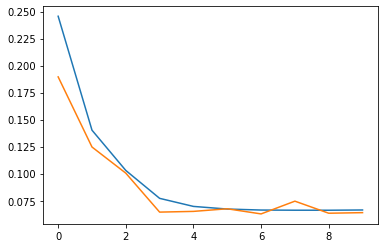

In [13]:
plt.plot(train_loss)
plt.plot(val_loss)

In [14]:
#model_ =  nn.RNN(5,1,2, batch_first=True).to(device)
params = {
    'batch_size' : 32,
    'shuffle'    : False,
    'num_workers': 2
}

training_set         = Dataset( train_ids, data )
training_generator   = torch.utils.data.DataLoader( training_set, **params, pin_memory=True ) 
validation_set       = Dataset( test_ids, data )
validation_generator = torch.utils.data.DataLoader( validation_set, **params, pin_memory=True )

real = np.zeros(len(train_ids))
output = np.zeros(len(train_ids))
j = 0
for i,batch in enumerate(training_generator):
    real[j:j+batch[0].shape[0]] = batch[1]
    #output[j:j+batch[0].shape[0]] = model(batch[0].to(device)).cpu().detach().numpy()
    output[j:j+batch[0].shape[0]] = model(batch[0].unsqueeze(1).to(device))[0][:,0,0].cpu().detach().numpy()
    j += batch[0].shape[0]

(0.0, 1000.0)

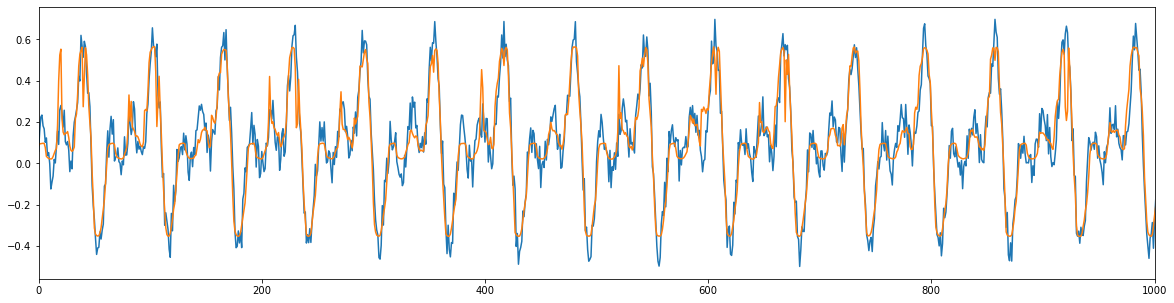

In [15]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)

(0.0, 1000.0)

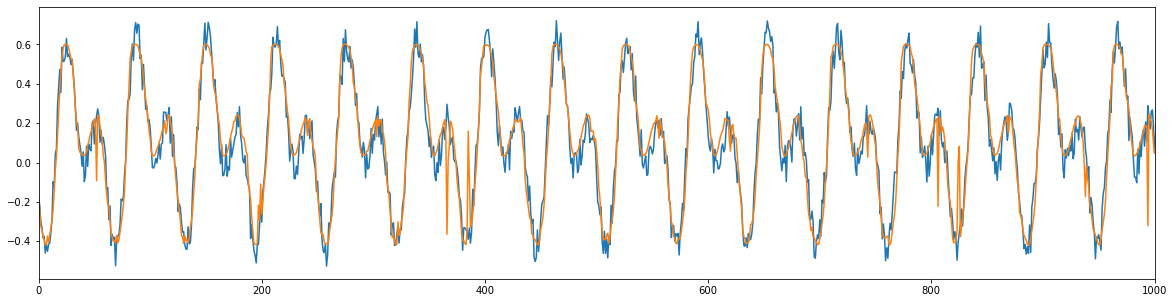

In [30]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)

(0.0, 1000.0)

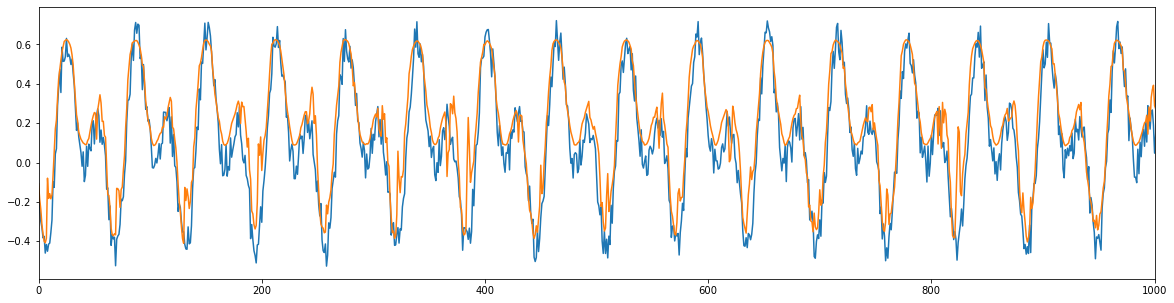

In [20]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)

In [16]:
real = np.zeros(len(test_ids))
output = np.zeros(len(test_ids))
j = 0
for i,batch in enumerate(validation_generator):
    real[j:j+batch[0].shape[0]] = batch[1]
    #output[j:j+batch[0].shape[0]] = model(batch[0].to(device)).cpu().detach().numpy()
    output[j:j+batch[0].shape[0]] = model(batch[0].unsqueeze(1).to(device))[0][:,0,0].cpu().detach().numpy()
    j += batch[0].shape[0]

(0.0, 1000.0)

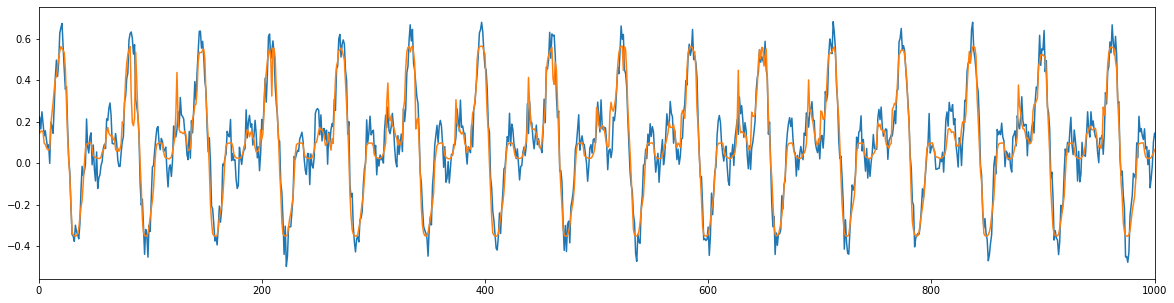

In [17]:
plt.figure(figsize=(20,5))
plt.plot(real)
plt.plot(output)
plt.xlim(0,1000)

In [291]:
from scipy import stats

In [292]:
stats.pearsonr( real, output )

(0.8870405134414633, 0.0)

OrderedDict([('weight_ih_l0',
              tensor([[-0.6020, -0.5538, -0.4736, -0.4147, -0.3035, -0.1991, -0.0787,  0.0873,
                        0.2704,  0.5198]], device='cuda:0')),
             ('weight_hh_l0', tensor([[-7.5670e-43]], device='cuda:0')),
             ('bias_ih_l0', tensor([-0.2098], device='cuda:0')),
             ('bias_hh_l0', tensor([-0.2088], device='cuda:0')),
             ('weight_ih_l1', tensor([[-1.1306]], device='cuda:0')),
             ('weight_hh_l1', tensor([[-9.9913e-43]], device='cuda:0')),
             ('bias_ih_l1', tensor([0.0919], device='cuda:0')),
             ('bias_hh_l1', tensor([0.0919], device='cuda:0')),
             ('weight_ih_l2', tensor([[0.9226]], device='cuda:0')),
             ('weight_hh_l2', tensor([[2.4102e-43]], device='cuda:0')),
             ('bias_ih_l2', tensor([0.0932], device='cuda:0')),
             ('bias_hh_l2', tensor([-0.0646], device='cuda:0')),
             ('weight_ih_l3', tensor([[-0.7214]], device='cuda:0')),
  

In [37]:
time = np.arange(0,1002,0.1)
sin  = (np.sin(time) - np.sin(2*time) + np.sin(3*time))*0.6/3 + np.random.rand(len(time))*0.2

(0.0, 1000.0)

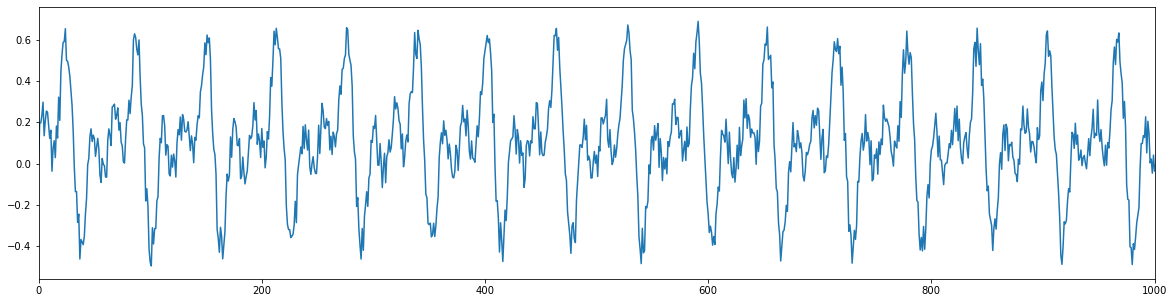

In [38]:
plt.figure(figsize=(20,5))
plt.plot(sin)
plt.xlim(0,1000)

In [157]:
np.random.rand(len(sin))*0.1

array([0.07943948, 0.02186241, 0.01262964, ..., 0.04865622, 0.09704156,
       0.02387521])

In [19]:
model = rnn_model()

In [20]:
model.state_dict()

OrderedDict([('rnn1.weight_ih_l0',
              tensor([[ 0.0279, -0.0171, -0.2121, -0.1567, -0.1455,  0.2074, -0.2138, -0.0593,
                       -0.1892,  0.2196],
                      [-0.1137,  0.1800, -0.0168, -0.1448, -0.1693,  0.1279,  0.1298,  0.0169,
                        0.0833,  0.0696],
                      [ 0.1165,  0.1651, -0.1756, -0.2201, -0.0363, -0.0916, -0.0396, -0.1070,
                       -0.2068,  0.0650],
                      [ 0.0717,  0.1865,  0.1203,  0.0048,  0.0638,  0.2077,  0.2119, -0.1244,
                        0.1286,  0.0782],
                      [-0.1737,  0.0565, -0.0848,  0.0003,  0.1133, -0.1234, -0.0686,  0.0183,
                       -0.1834,  0.2214],
                      [ 0.2155,  0.1289,  0.0254,  0.0729, -0.0411, -0.1518, -0.1063,  0.0865,
                       -0.2073,  0.0071],
                      [-0.1905,  0.2107, -0.0029,  0.1879, -0.0904, -0.1844,  0.2156, -0.0279,
                        0.1114,  0.0010],
      